In [1]:
! pip install -q "gdown==5.2.0"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoConfig
from PIL import Image
import requests
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Dataset

In [ ]:
!gdown --id 1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39

In [ ]:
!unzip lung_cancer_dataset.zip

In [5]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        # selected_files = random.sample(filelist, 20)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [6]:
data_dir = '/content/lung_cancer_dataset'
df = loading_the_data(data_dir)
df

,filepaths,labels
0,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
1,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
2,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
3,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
4,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
...,...,...
1195,/content/lung_cancer_dataset/Normal cases/Norm...,Normal cases
1196,/content/lung_cancer_dataset/Normal cases/Norm...,Normal cases
1197,/content/lung_cancer_dataset/Normal cases/Norm...,Normal cases
1198,/content/lung_cancer_dataset/Normal cases/Norm...,Normal cases


In [7]:
class LungCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_dict=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_dict = class_dict

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepaths']
        label = self.dataframe.iloc[idx]['labels']
        label = self.class_dict[label]
        label = torch.tensor(label)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
img_size = (224, 224)
batch_size = 32

In [9]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

classes = train_df['labels'].unique()
class_dict = {label: idx for idx, label in enumerate(classes)}
reverse_class_dict = {idx: label for label, idx in class_dict.items()}

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = LungCancerDataset(dataframe=train_df, transform=transform, class_dict=class_dict)
valid_dataset = LungCancerDataset(dataframe=valid_df, transform=transform, class_dict=class_dict)
test_dataset = LungCancerDataset(dataframe=test_df, transform=transform, class_dict=class_dict)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model

In [ ]:
# Define the Image Classification Model
class ImageClassificationModel(nn.Module):
    def __init__(self, num_classes):
        super(ImageClassificationModel, self).__init__()
        self.dino = AutoModel.from_pretrained('facebook/dinov2-large')
        self.fc = nn.Linear(self.dino.config.hidden_size, num_classes)

    def forward(self, x):
        x = self.dino(x).last_hidden_state[:, 0, :]
        x = self.fc(x)
        return x

# Initialize the model
num_classes = 3
model = ImageClassificationModel(num_classes)

# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last Dinov2Layer
for param in model.dino.encoder.layer[-1].parameters():
    param.requires_grad = True

# Optionally, also unfreeze the layernorm layer after the encoder
for param in model.dino.layernorm.parameters():
    param.requires_grad = True

# Optionally, unfreeze the classification head
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Train

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(valid_loader.dataset)

        print(f'Validation Accuracy: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model


model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10 | Loss: 3.0705 | Accuracy: 0.3281
Validation Accuracy: 0.3583
Epoch 2/10 | Loss: 1.1057 | Accuracy: 0.3781
Validation Accuracy: 0.5083
Epoch 3/10 | Loss: 0.9220 | Accuracy: 0.5406
Validation Accuracy: 0.6750
Epoch 4/10 | Loss: 0.6497 | Accuracy: 0.6583
Validation Accuracy: 0.6750
Epoch 5/10 | Loss: 0.7654 | Accuracy: 0.6521
Validation Accuracy: 0.6667
Epoch 6/10 | Loss: 0.5162 | Accuracy: 0.7781
Validation Accuracy: 0.8000
Epoch 7/10 | Loss: 0.3049 | Accuracy: 0.8771
Validation Accuracy: 0.8500
Epoch 8/10 | Loss: 0.1864 | Accuracy: 0.9219
Validation Accuracy: 0.9333
Epoch 9/10 | Loss: 0.2285 | Accuracy: 0.9146
Validation Accuracy: 0.9417
Epoch 10/10 | Loss: 0.0886 | Accuracy: 0.9708
Validation Accuracy: 0.9583


# Test

In [12]:
# Test the model
model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9583


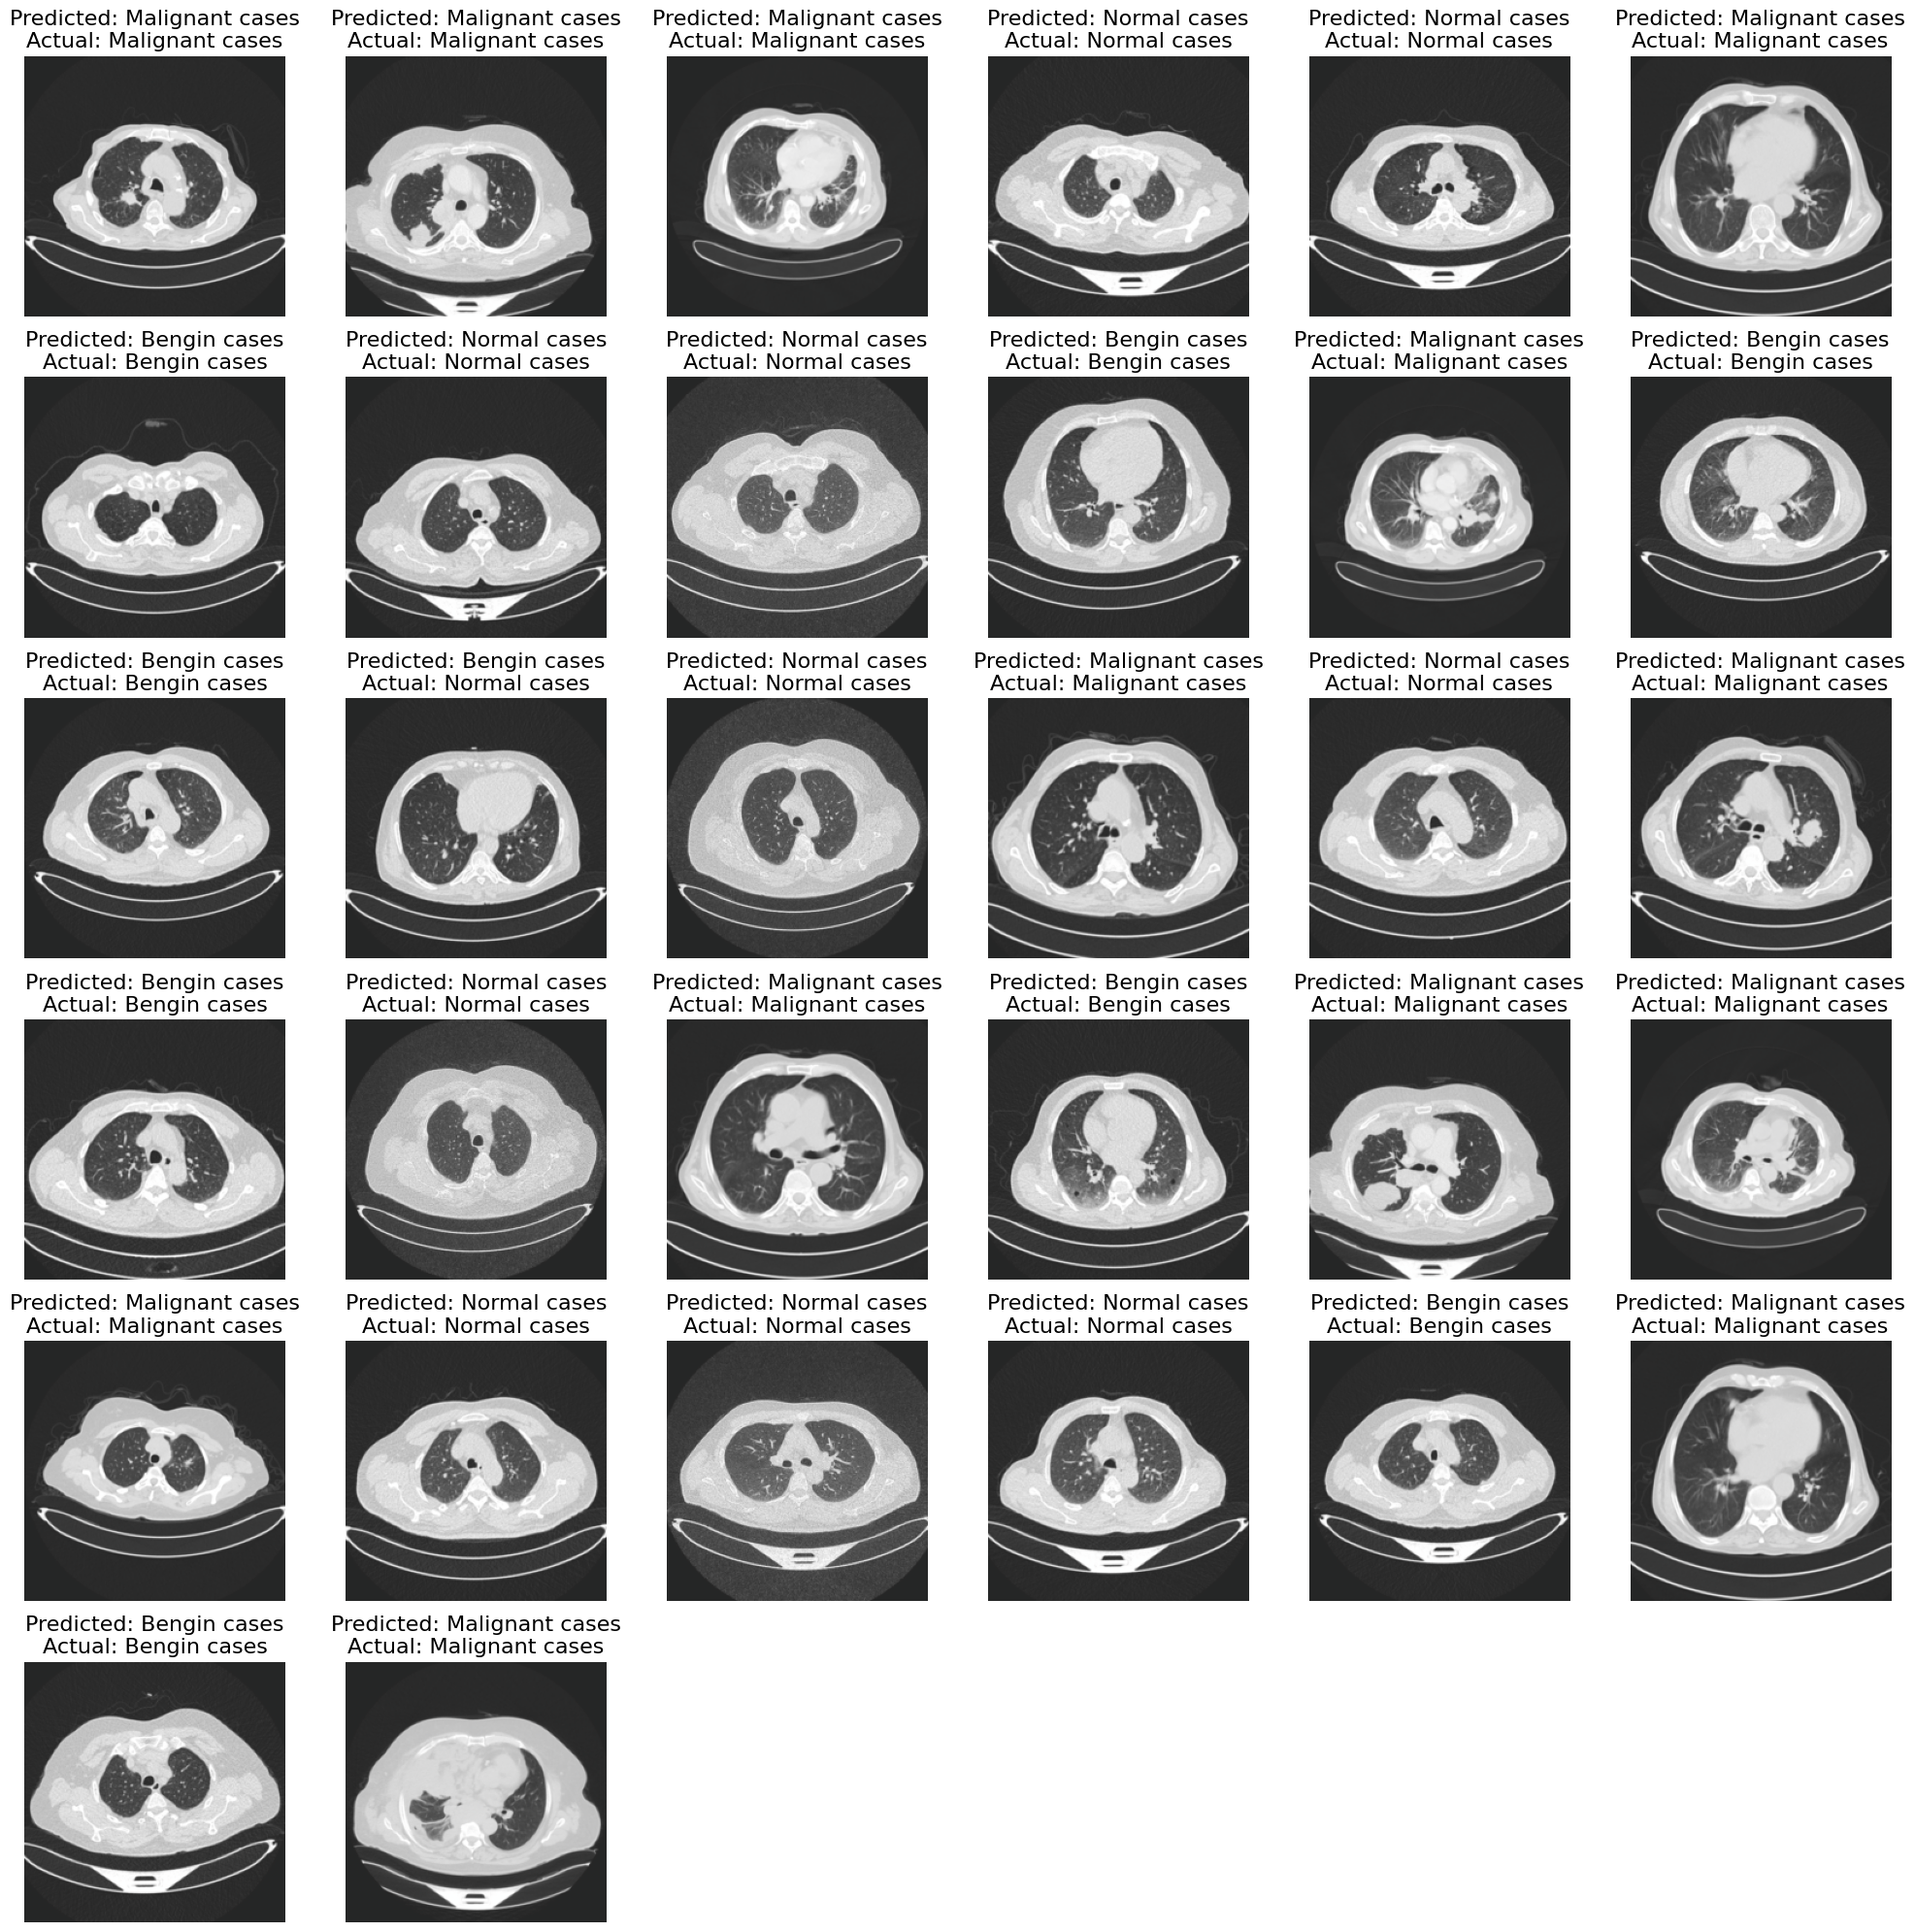

In [13]:
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Convert images to CPU and unnormalize
inputs = inputs.cpu().numpy().transpose(0, 2, 3, 1)
inputs = np.clip(inputs * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

plt.figure(figsize=(20, 20))
for i in range(len(inputs)):
    plt.subplot(6, 6, i + 1)
    plt.imshow(inputs[i])
    plt.title(f'Predicted: {reverse_class_dict[preds[i].item()]}\nActual: {reverse_class_dict[labels[i].item()]}', color='black', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
torch.save(model.state_dict(), "dinov2_lung_cancer_detection.pth")

# Push to Hub

In [15]:
from google.colab import userdata
from huggingface_hub import login, HfApi, create_repo

In [16]:
login(token=userdata.get('niru_hf_write'))

In [ ]:
create_repo("nirusanan/Lung_Cancer_Detection_DinoV2", private=True)

In [ ]:
from huggingface_hub import upload_file

# Upload a single file
upload_file(
    path_or_fileobj="/content/dinov2_lung_cancer_detection.pth",
    path_in_repo="dinov2_lung_cancer_detection.pth",
    repo_id="nirusanan/Lung_Cancer_Detection_DinoV2",
    repo_type="model",
)
